# Sentiment Analysis on Movie Reviews


## Problem Statement

This Kaggle competition focuses on performing sentiment analysis using the Rotten Tomatoes movie review dataset. The primary problem of the competition is to classify different phrases and sub-phrases from movie reviews into a specific sentiment category.

### Problem Description:

The goal of this competition is to predict the sentiment label for each phrase in movie reviews. These phrases can be full sentences or smaller segments within a sentence. Participants are tasked with labeling these phrases based on five sentiment categories:

- **0** - Negative
- **1** - Somewhat Negative
- **2** - Neutral
- **3** - Somewhat Positive
- **4** - Positive

This classification task presents several challenges. For instance:
- **Negation**: Sentences with negation (e.g., "not bad at all") can shift the overall meaning.
- **Sarcasm**: Sometimes, an expression may seem positive on the surface but carry a negative sentiment.
- **Language complexity**: Short or ambiguous phrases can make identifying the correct sentiment difficult.

### Dataset:

The dataset, derived from Rotten Tomatoes movie reviews, has been structured in a treebank format, allowing the analysis of not just full sentences but also sub-phrases within sentences. It contains sentiment labels for these sentences and sub-phrases.

### Solution Approach:

This problem can be addressed using machine learning techniques, particularly **Natural Language Processing (NLP)** methods. Here is a high-level approach to the solution:

1. **Data Preparation**:
   - The text data needs to be cleaned (preprocessing, handling grammatical errors, removing stopwords, etc.).
   - Sentences and sub-phrases should be vectorized, i.e., converted into numerical formats (e.g., using TF-IDF, Word2Vec, or modern language models like BERT).

2. **Model Training**:
   - A machine learning model is selected for this task. The model learns to predict the sentiment classes using the training data.
   - Classic methods include algorithms like **Logistic Regression** and **Support Vector Machines (SVM)**.
   - Modern methods include **deep learning** approaches, particularly RNN, LSTM, and **transformer-based models** (BERT, GPT, etc.). These methods are effective in capturing complex language structures and sentiment nuances.

3. **Model Testing and Evaluation**:
   - During training, the model’s accuracy is evaluated. Accuracy is measured as the proportion of correctly predicted sentiment labels.

4. **Challenges**:
   - Due to the complexity and ambiguity of language, predicting sentiment labels accurately can be difficult.
   - For example, subtle differences in reviews can make it hard for a model to distinguish between "somewhat positive" and "positive."

### Competition Evaluation:
Submissions are evaluated based on **classification accuracy**—the percentage of correctly predicted labels for each phrase. The higher the number of correct predictions, the better the score.

In summary, this competition offers an opportunity for participants to practice and experiment with NLP and sentiment analysis techniques. By experimenting with various models on this dataset, participants can aim to develop an accurate sentiment classification model.


In [9]:
# from google.colab import files
# files.upload()

In [10]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [11]:
# !pip install -q kaggle

In [12]:
# !kaggle competitions download -c sentiment-analysis-on-movie-reviews

In [13]:
# !unzip sentiment-analysis-on-movie-reviews.zip

In [14]:
!pip install neattext

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings


import neattext.functions as nfx
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

warnings.filterwarnings("ignore")

In [16]:
df_train = pd.read_csv("train.tsv.zip",sep='\t')
df_test = pd.read_csv("test.tsv.zip", sep='\t')

## EDA - Exploratory Data Analysis

In [17]:
df_train.sample(10)

,PhraseId,SentenceId,Phrase,Sentiment
125506,125507,6744,'m giving it thumbs down due to the endlessly ...,0
39524,39525,1887,maiden,2
32736,32737,1535,Another in a long line of ultra-violent war mo...,3
138288,138289,7485,with all the dysfunctional family dynamics one...,3
122761,122762,6586,amused by the idea,3
76128,76129,3906,of films like Kangaroo Jack about to burst acr...,2
8033,8034,330,Hey Arnold ! ',2
47767,47768,2328,silly Hollywood action film,1
152525,152526,8322,"they be of nature , of man or of one another",2
121545,121546,6512,cultural and personal self-discovery and a pic...,3


In [18]:
df_test.sample(10)

,PhraseId,SentenceId,Phrase
955,157016,8572,", Amy 's Orgasm is not a porno , though it is ..."
27143,183204,9782,Christopher and Grace
46703,202764,10780,no cliche unturned
49860,205921,10948,a huge fan
60017,216078,11510,- eye
12647,168708,9080,of past and present
35315,191376,10190,oversize
14045,170106,9142,"A triumph of art direction over narrative , bu..."
54393,210454,11192,the Shadows of Motown
36239,192300,10235,to look away


In [19]:
df_train.shape, df_test.shape

((156060, 4), (66292, 3))

In [20]:
df_train.isnull().sum()

,0
PhraseId,0
SentenceId,0
Phrase,0
Sentiment,0


In [21]:
df_test.isnull().sum()

,0
PhraseId,0
SentenceId,0
Phrase,1


In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [23]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66291 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


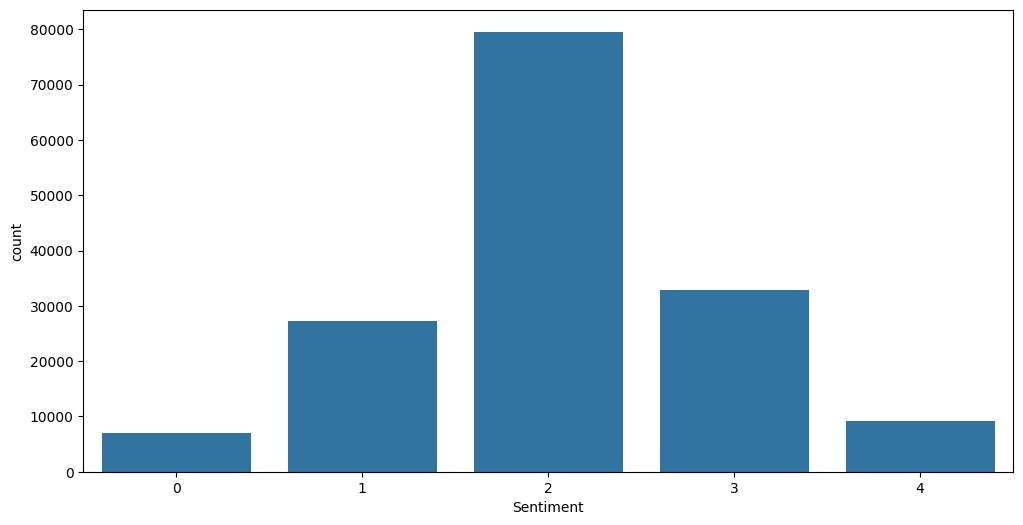

In [24]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=df_train)
plt.show()

In [25]:
def wc(data, title):
    plt.figure(figsize = (10,10))
    wc = WordCloud(background_color = 'white', stopwords= STOPWORDS)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.title('{} Word Cloud'.format(title))
    plt.axis('off')

In [26]:
sentiment_0 = df_train[df_train['Sentiment'] == 0]['Phrase']
sentiment_1 = df_train[df_train['Sentiment'] == 1]['Phrase']
sentiment_2 = df_train[df_train['Sentiment'] == 2]['Phrase']
sentiment_3 = df_train[df_train['Sentiment'] == 3]['Phrase']
sentiment_4 = df_train[df_train['Sentiment'] == 4]['Phrase']

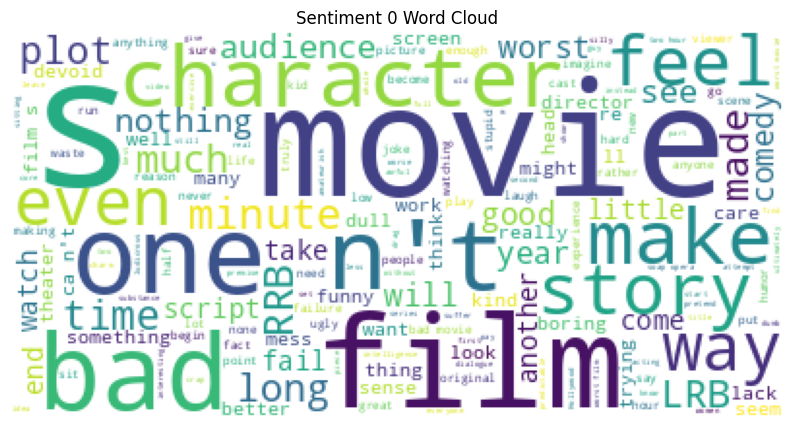

In [27]:
wc(sentiment_0, 'Sentiment 0')

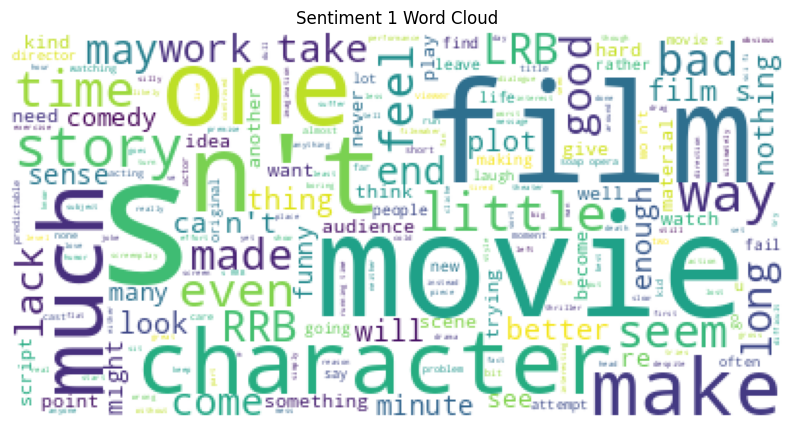

In [28]:
wc(sentiment_1, 'Sentiment 1')

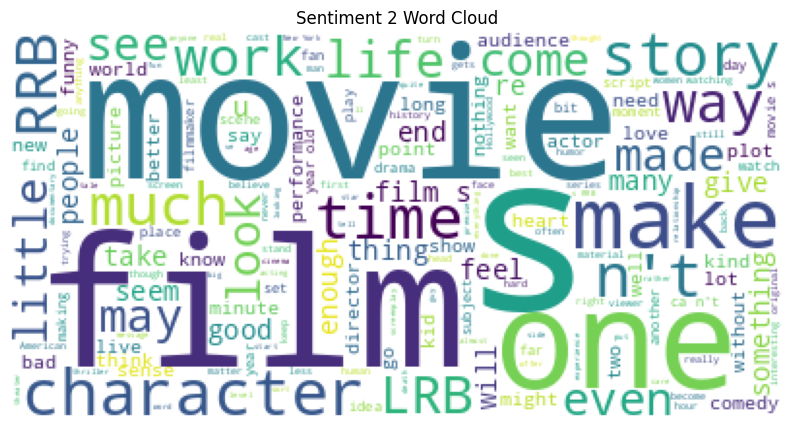

In [29]:
wc(sentiment_2, 'Sentiment 2')

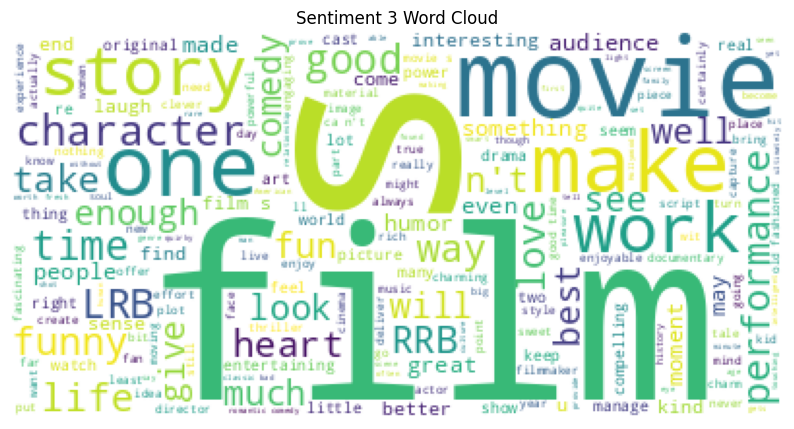

In [30]:
wc(sentiment_3, 'Sentiment 3')

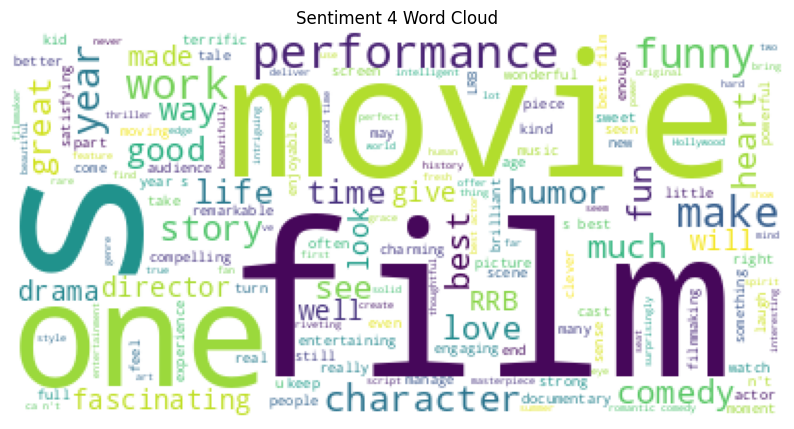

In [31]:
wc(sentiment_4, 'Sentiment 4')

In [32]:
s =' '.join(df_train['Phrase'].tolist())
s = nfx.remove_stopwords(s)
s = nfx.remove_special_characters(s)
s = nfx.remove_multiple_spaces(s)
data = Counter(s.split()).most_common(30)
data = dict(data)
data

{'s': 16971,
 'film': 6626,
 'movie': 5827,
 'nt': 3970,
 'like': 2870,
 'story': 2449,
 'RRB': 2438,
 'LRB': 2098,
 'good': 1972,
 'characters': 1882,
 'comedy': 1703,
 'time': 1594,
 'funny': 1508,
 'way': 1500,
 'little': 1498,
 'life': 1423,
 'movies': 1335,
 'work': 1227,
 'bad': 1125,
 'love': 1066,
 'people': 1052,
 'best': 1013,
 'makes': 1006,
 'action': 1002,
 'director': 1001,
 'plot': 970,
 'films': 970,
 'character': 949,
 'new': 904,
 'audience': 900}

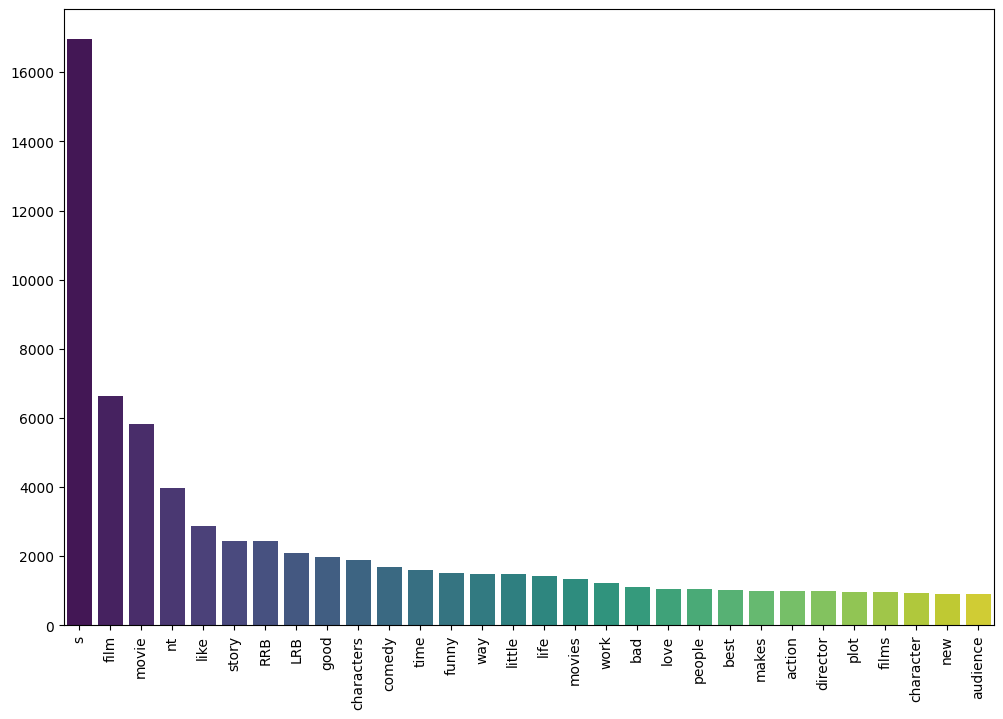

In [33]:
plt.figure(figsize=(12, 8))
sns.barplot(x=list(data.keys()), y=list(data.values()), palette='viridis')
plt.xticks(rotation=90);

In [34]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = nfx.clean_text(text)
    text = nfx.normalize(text)
    text = nfx.remove_special_characters(text)
    text = nfx.remove_stopwords(text)
    text = nfx.remove_numbers(text)
    text = nfx.remove_urls(text)
    text = nfx.remove_multiple_spaces(text)
    return text

In [35]:
df_train['Phrase'] = df_train['Phrase'].apply(clean_text)
df_test['Phrase'] = df_test['Phrase'].apply(clean_text)

In [36]:
x = df_train['Phrase']
y = df_train['Sentiment']

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [38]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((124848,), (31212,), (124848,), (31212,))

In [39]:
from sklearn.pipeline import Pipeline

def pipeline_fit(algorithm):
  pipeline = Pipeline([
      ('vect', CountVectorizer(preprocessor=clean_text)),
      ('tfidf',  TfidfTransformer()),
      ('clf', algorithm)
      ])
  print('{} fitting'.format(algorithm))
  pipeline.fit(x_train, y_train)
  print('{} fitted'.format(algorithm))

  y_pred = pipeline.predict(x_test)
  acc = accuracy_score(y_test, y_pred)
  return acc

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


algorithms_dict = {
    LogisticRegression(): "Logistic Regression",
    MultinomialNB(): "Naive Bayes",
    GradientBoostingClassifier(): "Gradient Boosting",
    XGBClassifier(): "XGBoost",
    LGBMClassifier(): "LightGBM"

}



In [41]:
# results = []
# for algorithm, name in algorithms_dict.items():
#   acc = pipeline_fit(algorithm)
#   results.append((name, acc))

# results_df = pd.DataFrame(results, columns=['Algorithm', 'Accuracy'])
# results_df

In [49]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [50]:
def data_preprocessing(df):
    reviews = []
    for raw in tqdm(df['Phrase']):
        text = BeautifulSoup(raw, 'lxml').get_text()
        letters_only = re.sub('[^a-zA-Z]', ' ', text)
        words = word_tokenize(letters_only.lower())
        stops = set(stopwords.words('english'))
        non_stopwords = [word for word in words if not word in stops]
        lemma_words = [lemmatizer.lemmatize(word) for word in non_stopwords]
        reviews.append(lemma_words)
    return reviews


train_sentences = data_preprocessing(df_train)
test_sentences = data_preprocessing(df_test)
len(train_sentences), len(test_sentences)


100%|██████████| 66292/66292 [00:37<00:00, 1756.79it/s]


(156060, 66292)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
target = df_train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

x_train, x_val, y_train, y_val = train_test_split(train_sentences, y_target, test_size=0.2, stratify=y_target, random_state=42)

from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

unique_words = set()
len_max = 0
for sent in tqdm(x_train):
    unique_words.update(sent)
    if len_max < len(sent):
        len_max = len(sent)


print(len(list(unique_words)), len_max)


tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(test_sentences)

x_train = sequence.pad_sequences(x_train, maxlen=len_max)
x_val = sequence.pad_sequences(x_val, maxlen=len_max)
x_test = sequence.pad_sequences(x_test, maxlen=len_max)

x_train.shape, x_val.shape, x_test.shape

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=len_max))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
submission = pd.read_csv('data/sampleSubmission.csv')
submission.Sentiment = y_pred

In [ ]:
# model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=256, callbacks=[early_stopping, checkpoint])

In [ ]:
submission

In [ ]:
submission.to_csv('submission_lstm.csv', index=False)

In [51]:
pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00


In [52]:
pip install tf-keras

In [59]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [54]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(data, max_len=128):
    return tokenizer(
        data['Phrase'].tolist(),
        max_length=max_len,
        padding=True,
        truncation=True,
        return_tensors="tf"
    )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [55]:
x_train, x_val, y_train, y_val = train_test_split(df_train[['Phrase']], df_train['Sentiment'], test_size=0.2, random_state=42)

In [56]:
train_encodings = tokenize_data(x_train)
val_encodings = tokenize_data(x_val)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)

In [57]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
optimizer = Adam(learning_rate=3e-5)
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [62]:
history = model.fit(
    train_encodings['input_ids'], y_train,
    validation_data=(val_encodings['input_ids'], y_val),
    epochs=3,
    batch_size=16
)

Epoch 1/3
7803/7803 [==============================] - 1405s 174ms/step - loss: 1.2910 - accuracy: 0.5117 - val_loss: 1.2987 - val_accuracy: 0.5011
Epoch 2/3
7803/7803 [==============================] - 1354s 174ms/step - loss: 1.2872 - accuracy: 0.5120 - val_loss: 1.2982 - val_accuracy: 0.5011
Epoch 3/3
7803/7803 [==============================] - 1320s 169ms/step - loss: 1.2849 - accuracy: 0.5122 - val_loss: 1.2978 - val_accuracy: 0.5011


In [71]:
test_encodings = tokenize_data(df_test)
y_pred = model.predict(test_encodings['input_ids'])

2072/2072 [==============================] - 184s 89ms/step


In [77]:
logits = y_pred.logits
y_pred_class = np.argmax(logits, axis=1)

In [78]:
submission_df = pd.DataFrame({
    'PhraseId': df_test['PhraseId'],
    'Sentiment': y_pred_class
})
submission_df

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,2
66288,222349,2
66289,222350,2
66290,222351,2


In [79]:
submission_df.to_csv('submission_bert.csv', index=False)